## GT Sampler

In [1]:
import sys
sys.path.append("../..")
sys.path.append("..")
import os
os.chdir("../../")

from GeoRCG_models.rep_samplers import initilize_rep_sampler
from omegaconf import OmegaConf
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from qm9 import dataset
from qm9.models import DistributionNodes, DistributionProperty
from configs.datasets_config import get_dataset_info
from qm9.utils import prepare_context, compute_mean_mad
import datetime
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
device = "cuda:1"
batch_size = 10000
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
from pathlib import Path
save_dir = Path(f"eval_src/visualize_results/rep_clustering_{current_time}")
save_dir.mkdir(parents=True, exist_ok=True)

fused_multi_tensor is not installed corrected
fused_rounding is not installed corrected
fused_layer_norm is not installed corrected
fused_softmax is not installed corrected


In [2]:
# Intialize dataset config for **unconditional qm9**
dataset_args = {
    "dataset": "qm9",
    "conditioning": [],
    "include_charges": True,
    "world_size": 1,
    "rank": 0,
    "filter_n_atoms": None,
    "remove_h": False,
    "batch_size": 128,
    "num_workers": 4,
    "datadir": "./data"
}

In [3]:
# Init dataset, dataloaderes and property samplers

dataset_args = OmegaConf.create(dataset_args)
dataloaders, charge_scale = dataset.retrieve_dataloaders(dataset_args)
dataloader_train = dataloaders["train"]

dataset_info = get_dataset_info(dataset_args.dataset, dataset_args.remove_h)

histogram = dataset_info['n_nodes']
in_node_nf = len(dataset_info['atom_decoder']) + int(dataset_args.include_charges)
nodes_dist = DistributionNodes(histogram)

prop_dist = None
if len(dataset_args.conditioning) > 0:
    dataloaders, charge_scale = dataset.retrieve_dataloaders(dataset_args)
    prop_dist = DistributionProperty(dataloader_train, dataset_args.conditioning)
    property_norms = compute_mean_mad(dataloaders, dataset_args.conditioning, dataset_args.dataset)
    prop_dist.set_normalizer(property_norms)

In [4]:
sampler = "GtSampler"
Gt_dataset = "train"
encoder_path = "./checkpoints/encoder_ckpts/QM9.ckpt"
encoder_type = "frad"

rep_sampler_args = {
    "sampler": sampler,
    "Gt_dataset": Gt_dataset,
    "encoder_path": encoder_path,
    "encoder_type": encoder_type
}
rep_sampler_args = OmegaConf.create(rep_sampler_args)

gtsampler = initilize_rep_sampler(rep_sampler_args, device, dataset_args=dataset_args)

/home/lizian/miniconda3/envs/new_sc/lib/python3.8/site-packages/torch_geometric/nn/conv/message_passing.py:1032: UserWarning: 'NeighborEmbedding.jittable' is deprecated and a no-op. Please remove its usage.
  warnings.warn(f"'{self.__class__.__name__}.jittable' is deprecated "
/home/lizian/miniconda3/envs/new_sc/lib/python3.8/site-packages/torch_geometric/nn/conv/message_passing.py:1032: UserWarning: 'EquivariantMultiHeadAttention.jittable' is deprecated and a no-op. Please remove its usage.
  warnings.warn(f"'{self.__class__.__name__}.jittable' is deprecated "
/home/lizian/Self-Conditioned-3D-Diffusion/models/torchmdnet/models/model.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a

Using Gt Sampler for REP Sampling!


In [5]:
sampler = "PCSampler"
rdm_ckpt = "./checkpoints/rdm_ckpts/rdm_batch128_pretrainedEnc"
inv_temp = 1.0
n_steps = 5
snr = 0.01

rep_sampler_args = {
    "sampler": sampler,
    "rdm_ckpt": rdm_ckpt,
    "inv_temp": inv_temp,
    "n_steps": n_steps,
    "snr": snr
}
rep_sampler_args = OmegaConf.create(rep_sampler_args)

pcsampler = initilize_rep_sampler(rep_sampler_args, device, dataset_args=dataset_args)

Loading RDM from ./checkpoints/rdm_ckpts/rdm_batch128_pretrainedEnc


/home/lizian/Self-Conditioned-3D-Diffusion/models/util/misc.py:389: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(resume_path, map_location='cpu')


RDM: Running in x0-prediction mode
DiffusionWrapper has 100.56 M params.
Using PC Sampler for REP Sampling!
Different in betas when initializing VPSDE! We use betas in the trained model.


## Seperate

In [6]:
print("Sampling GT Reps...")
gt_nodesxsample = nodes_dist.sample(batch_size)
gt_addtional_cond = None
if prop_dist is not None:
    gt_addtional_cond = prop_dist.sample_batch(gt_nodesxsample)
gt_reps = gtsampler.sample(
    device=device,
    nodesxsample=gt_nodesxsample,
    additional_cond=gt_addtional_cond,
    running_batch_size=1000,
)
gt_y = torch.zeros((gt_reps.shape[0]), device=device)
print("Finished Sampling GT Reps.")

Sampling GT Reps...


100%|██████████| 10/10 [03:06<00:00, 18.69s/it]

Finished Sampling GT Reps.


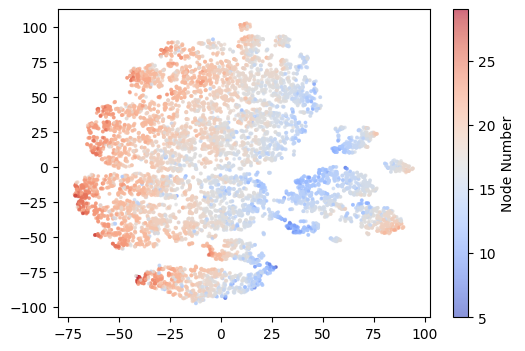

In [7]:
gt_reps_transformed = gt_reps.cpu().numpy()
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(gt_reps_transformed)

# Step 3: Visualize the results
plt.figure(figsize=(6, 4))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=gt_nodesxsample.cpu().numpy(), cmap='coolwarm', alpha=0.6, s=3)
plt.colorbar(scatter, label='Node Number')
plt.savefig(save_dir/"qm9_data_rep_clustering.pdf", bbox_inches='tight',  # Ensure no extra white space around the figure
            pad_inches=0,       # Minimal padding
            dpi=800)              # High resolution (300 DPI)
plt.show()

In [8]:
print("Sampling PC Reps...")
pc_nodesxsample = nodes_dist.sample(batch_size)
pc_addtional_cond = None
if prop_dist is not None:
    pc_addtional_cond = prop_dist.sample_batch(pc_nodesxsample)
pc_reps = pcsampler.sample(
    device=device,
    nodesxsample=pc_nodesxsample,
    additional_cond=pc_addtional_cond,
    running_batch_size=1000,
)
pc_y = torch.ones((pc_reps.shape[0]), device=device)
print("Finished Sampling PC Reps.")

Sampling PC Reps...


100%|██████████| 10/10 [31:35<00:00, 189.53s/it]

Finished Sampling PC Reps.


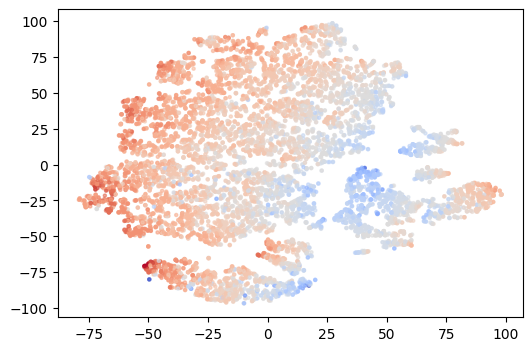

In [9]:
pc_reps_transformed = pc_reps.cpu().numpy()
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(pc_reps_transformed)

# Step 3: Visualize the results
plt.figure(figsize=(6, 4))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=pc_nodesxsample.cpu().numpy(), cmap='coolwarm', alpha=0.6, s=5)
plt.savefig(save_dir / "qm9_sampler_rep_clustering.pdf", bbox_inches='tight',  # Ensure no extra white space around the figure
            pad_inches=0,       # Minimal padding
            dpi=800)              # High resolution (300 DPI)
plt.show()

## Together

/tmp/ipykernel_3841281/3313799794.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')


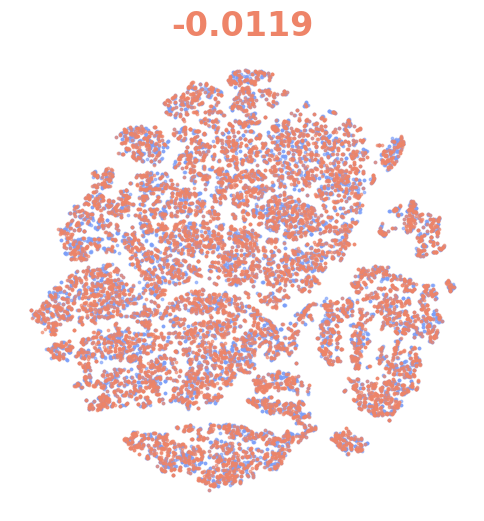

In [10]:
from matplotlib import cm

#  Step 1: Combine representations and labels
combined_reps = torch.cat((gt_reps, pc_reps), dim=0).cpu().numpy()
combined_y = torch.cat((gt_y, pc_y), dim=0).cpu().numpy()

# Step 2: Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(combined_reps)

# Step 3: Calculate Silhouette Score
ss_score = silhouette_score(tsne_results, combined_y) * 10000

# Step 4: Get cool and warm colors from the "coolwarm" colormap
cmap = cm.get_cmap('coolwarm')
cool_color = cmap(0.2)  # Cool color (start of the colormap)
warm_color = cmap(0.8)  # Warm color (end of the colormap)

# Step 5: Visualize the t-SNE results without axis ticks, legend, and add SS score
plt.figure(figsize=(6, 6))
plt.scatter(tsne_results[combined_y == 0, 0], tsne_results[combined_y == 0, 1], 
            alpha=0.6, color=cool_color, s=3)
plt.scatter(tsne_results[combined_y == 1, 0], tsne_results[combined_y == 1, 1], 
            alpha=0.6, color=warm_color, s=3)

# Step 6: Remove x and y ticks
plt.xticks([])
plt.yticks([])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
# Step 7: Add the silhouette score as text above the plot
plt.text(0.5, 1.05, f'{ss_score:.4f}', 
         horizontalalignment='center', 
         verticalalignment='center', 
         transform=plt.gca().transAxes, 
         fontsize=24, fontweight='bold', color=cmap(0.8))

# Step 8: Remove the legend
plt.gca().legend_ = None

# Step 9: Show the plot
plt.savefig(save_dir / "qm9_data_sampler_rep_clustering.pdf", bbox_inches='tight',  # Ensure no extra white space around the figure
            pad_inches=0,       # Minimal padding
            dpi=500)              # High resolution (300 DPI)
plt.show()